<font size="3">**Tarea 1 2025**</font>

<u> *Instrucciones* </u>

Su notebook con las respuestas a la tarea se deben entregar a mas tardar el dia 21/04/25 hasta las 21:00, subiendolo al repositorio en la carpeta tareas/2025. 

Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. La data a utilizar es **machine_failure_data.csv**.

Las variables tienen la siguiente descripcion:

- Date: data medida en frecuencia diaria
- Location: ubicacion del medidor
- Min_Temp: temperatura minima observada
- Max_Temp: temperatura maxima observada
- Leakage: Filtracion medida en el area
- Evaporation: Tasa de evaporacion
- Electricity: Consumo electrico KW
- Parameter#: Diferentes sensores de reportando direccion y velocidad de viento en distintos momentos del dia, asi como otras metricas relevantes.
- Failure today: El sensor reporta fallo (o no)

## TAREA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
import math
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### 1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. 

**R:** Primero que nada cargamos la data, trabajamos la data para que el formato sea adecuado para los procesamientos posteriores y las limpiezas estimadas, los procesos aplicados estaran escritos a lo largo del codigo

In [2]:
#Cargar la data
df = pd.read_csv('DATA/machine_failure_data.csv')

In [3]:
#filtrar por las fechas de interes(posterior a 2009) y generar columnas de año y mes
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['año'] = df['Date'].dt.year
df['mes'] = df['Date'].dt.month
df_02 = df[df['año'] >= 2009]

In [4]:
#Generar una variable binaria en base a la columna Failure
df_02['Failure_today_bin'] = df_02['Failure_today'].map({'Yes': 1, 'No': 0})

In [5]:
#Generalizar las direcciones en 4 opciones solamente, norte(N), sur(S), este(E) y oeste(W), para simplificar analisis
df_02['Parameter1_Dir'] = df['Parameter1_Dir'].str[0]
df_02['Parameter2_9am'] = df['Parameter2_9am'].str[0]
df_02['Parameter2_3pm'] = df['Parameter2_3pm'].str[0]

In [6]:
#Generar variables binarias en base a cada categoria de las variables categoricas
df_02 = pd.get_dummies(df_02, prefix=['Location','Parameter1_Dir', 'Parameter2_9am','Parameter2_3pm'], columns=['Location','Parameter1_Dir', 'Parameter2_9am','Parameter2_3pm'],dtype = int,drop_first=True)

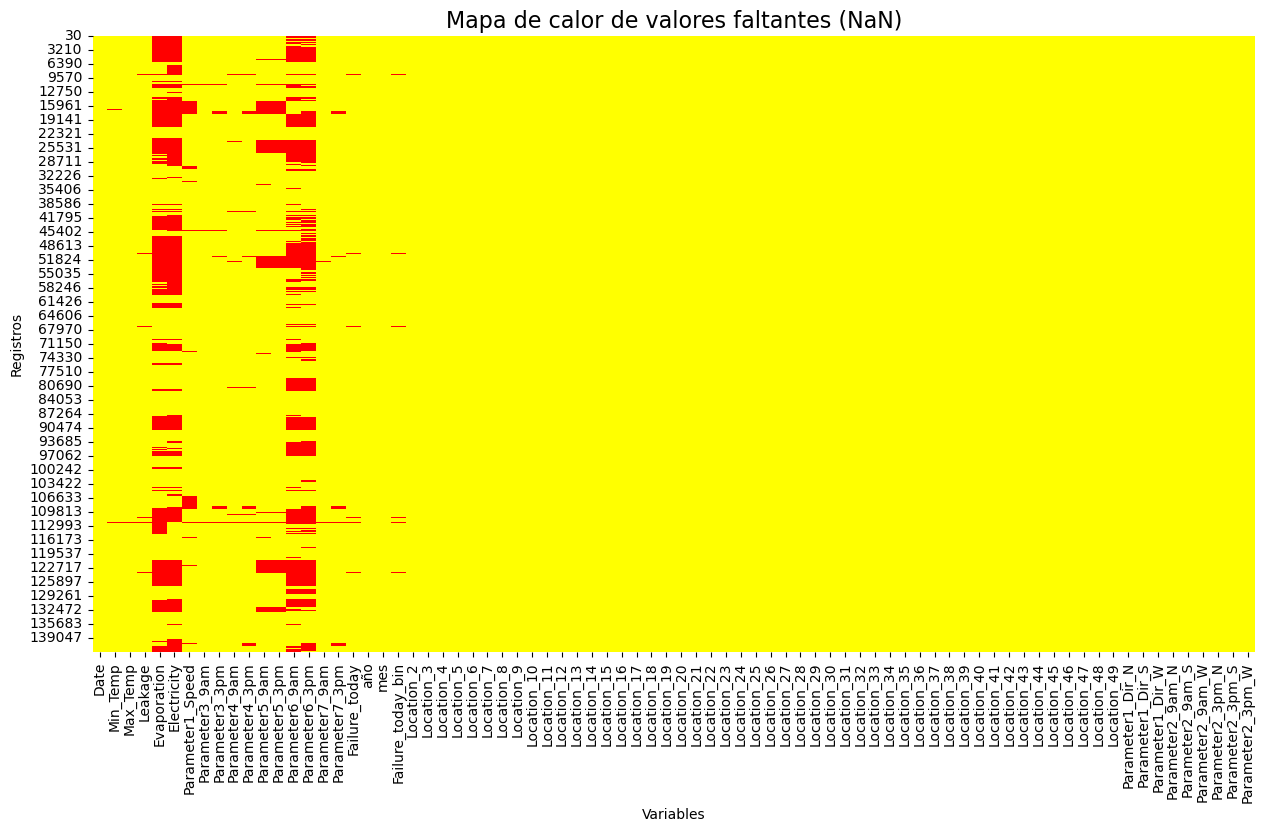

In [7]:
#Generamos un mapa de calor para identificar visualmente las variables con mas NaN
plt.figure(figsize=(15, 8))
sns.heatmap(df_02.isnull(), cbar=False, cmap=sns.color_palette(["yellow", "red"]))  # yellow = no NaN, red = NaN
plt.title("Mapa de calor de valores faltantes (NaN)", fontsize=16)
plt.xlabel("Variables")
plt.ylabel("Registros")
plt.show()

In [8]:
#Habiendo obtenido que las variables mas destacadas por su cantidad de NaN son Electricity y Evaporation
#Por lo cual, para no eliminar tan gran cantidad de datos generamos una columna indicadora de las veces que las variables no tuvieran valor para poder reconocerlos mas adelante en el analisis
df_03=df_02.copy()
df_03['Electricity_bin'] = df_03['Electricity'].isna().astype(int)
df_03.Electricity=df_03.Electricity.fillna(0)
df_03['Evaporation_bin'] = df_03['Evaporation'].isna().astype(int)
df_03.Evaporation=df_03.Evaporation.fillna(0)

In [9]:
#Posteriormente eliminamos las variablea continuación en los casos que, se hayan generado otras columnas con su informacion y ya no sean necesarias
#si es que no tienen valores o en el caso que su pertenencia en el df pueda afectar negativamente las estimaciones a continuacion como en los casos de 'Parameter6_9am', 'Parameter6_3pm' y 'Leakage'
df_03 = df_03.drop(['Date','Parameter6_9am', 'Parameter6_3pm','Leakage','Failure_today','Location_2','Location_24','Location_25','Location_31','Location_37'], axis=1)
df_03=df_03.dropna()


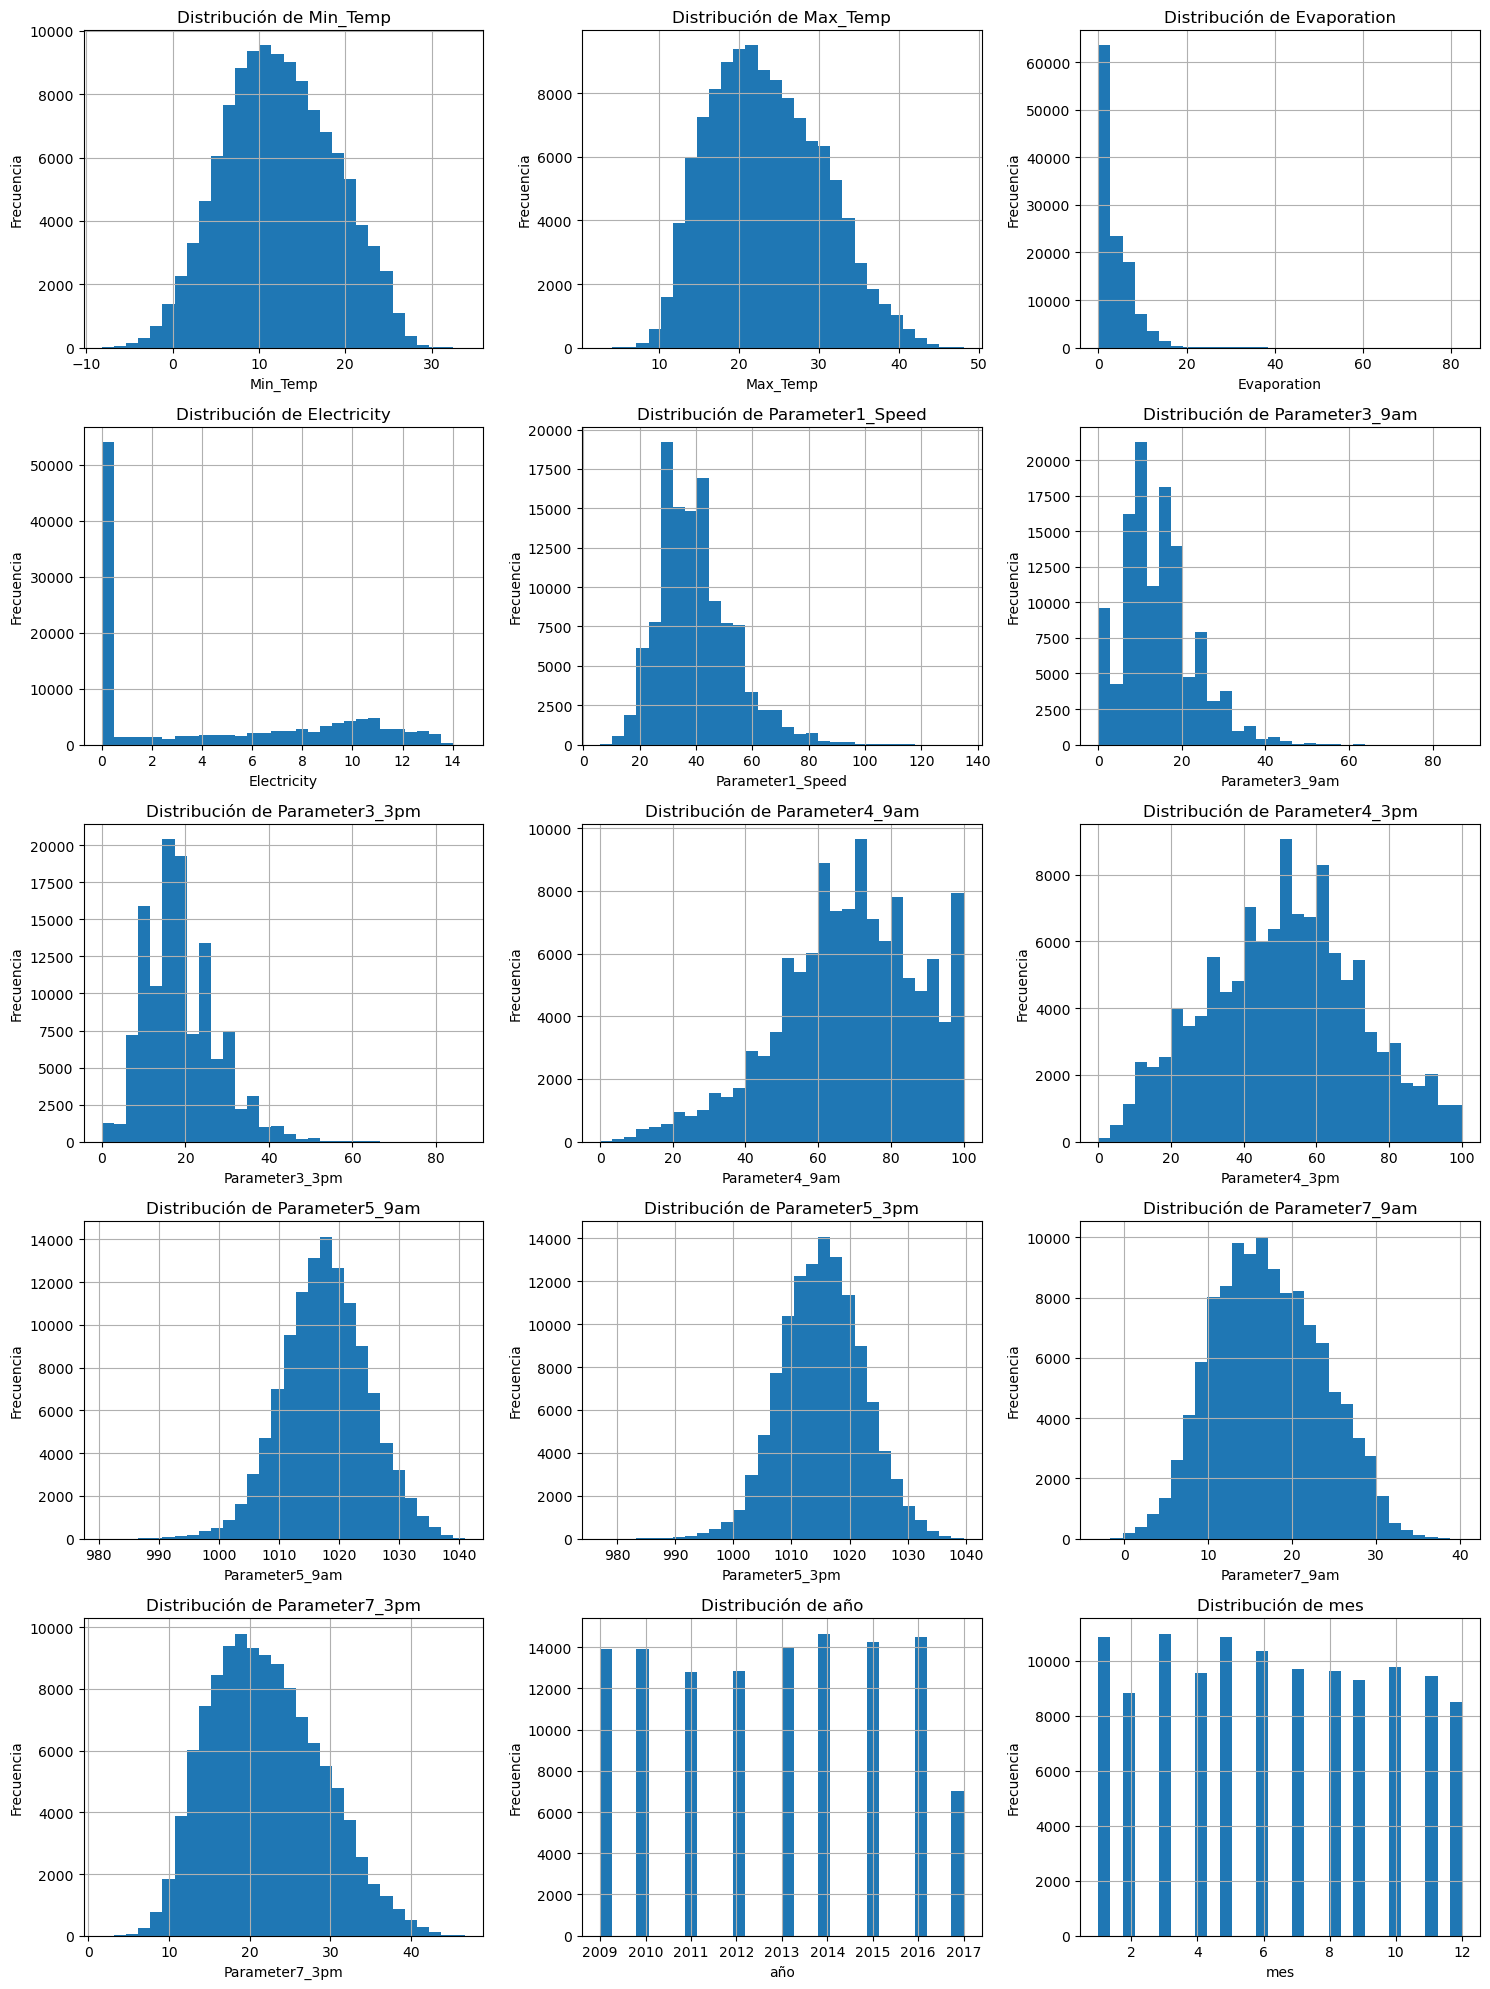

In [10]:
#Graficamos las distribuciones de las variables para facilitar su analisis

columnas_numericas = (df.drop(['Location','Leakage','Parameter6_9am', 'Parameter6_3pm'],axis=1)).select_dtypes(include='number').columns

num_columnas = 3
num_graficos = len(columnas_numericas)
num_filas = math.ceil(num_graficos / num_columnas)

fig, axes = plt.subplots(num_filas, num_columnas, figsize=(num_columnas * 5, num_filas * 4))
axes = axes.flatten()

# Generar cada histograma
for i, col in enumerate(columnas_numericas):
    df_03[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


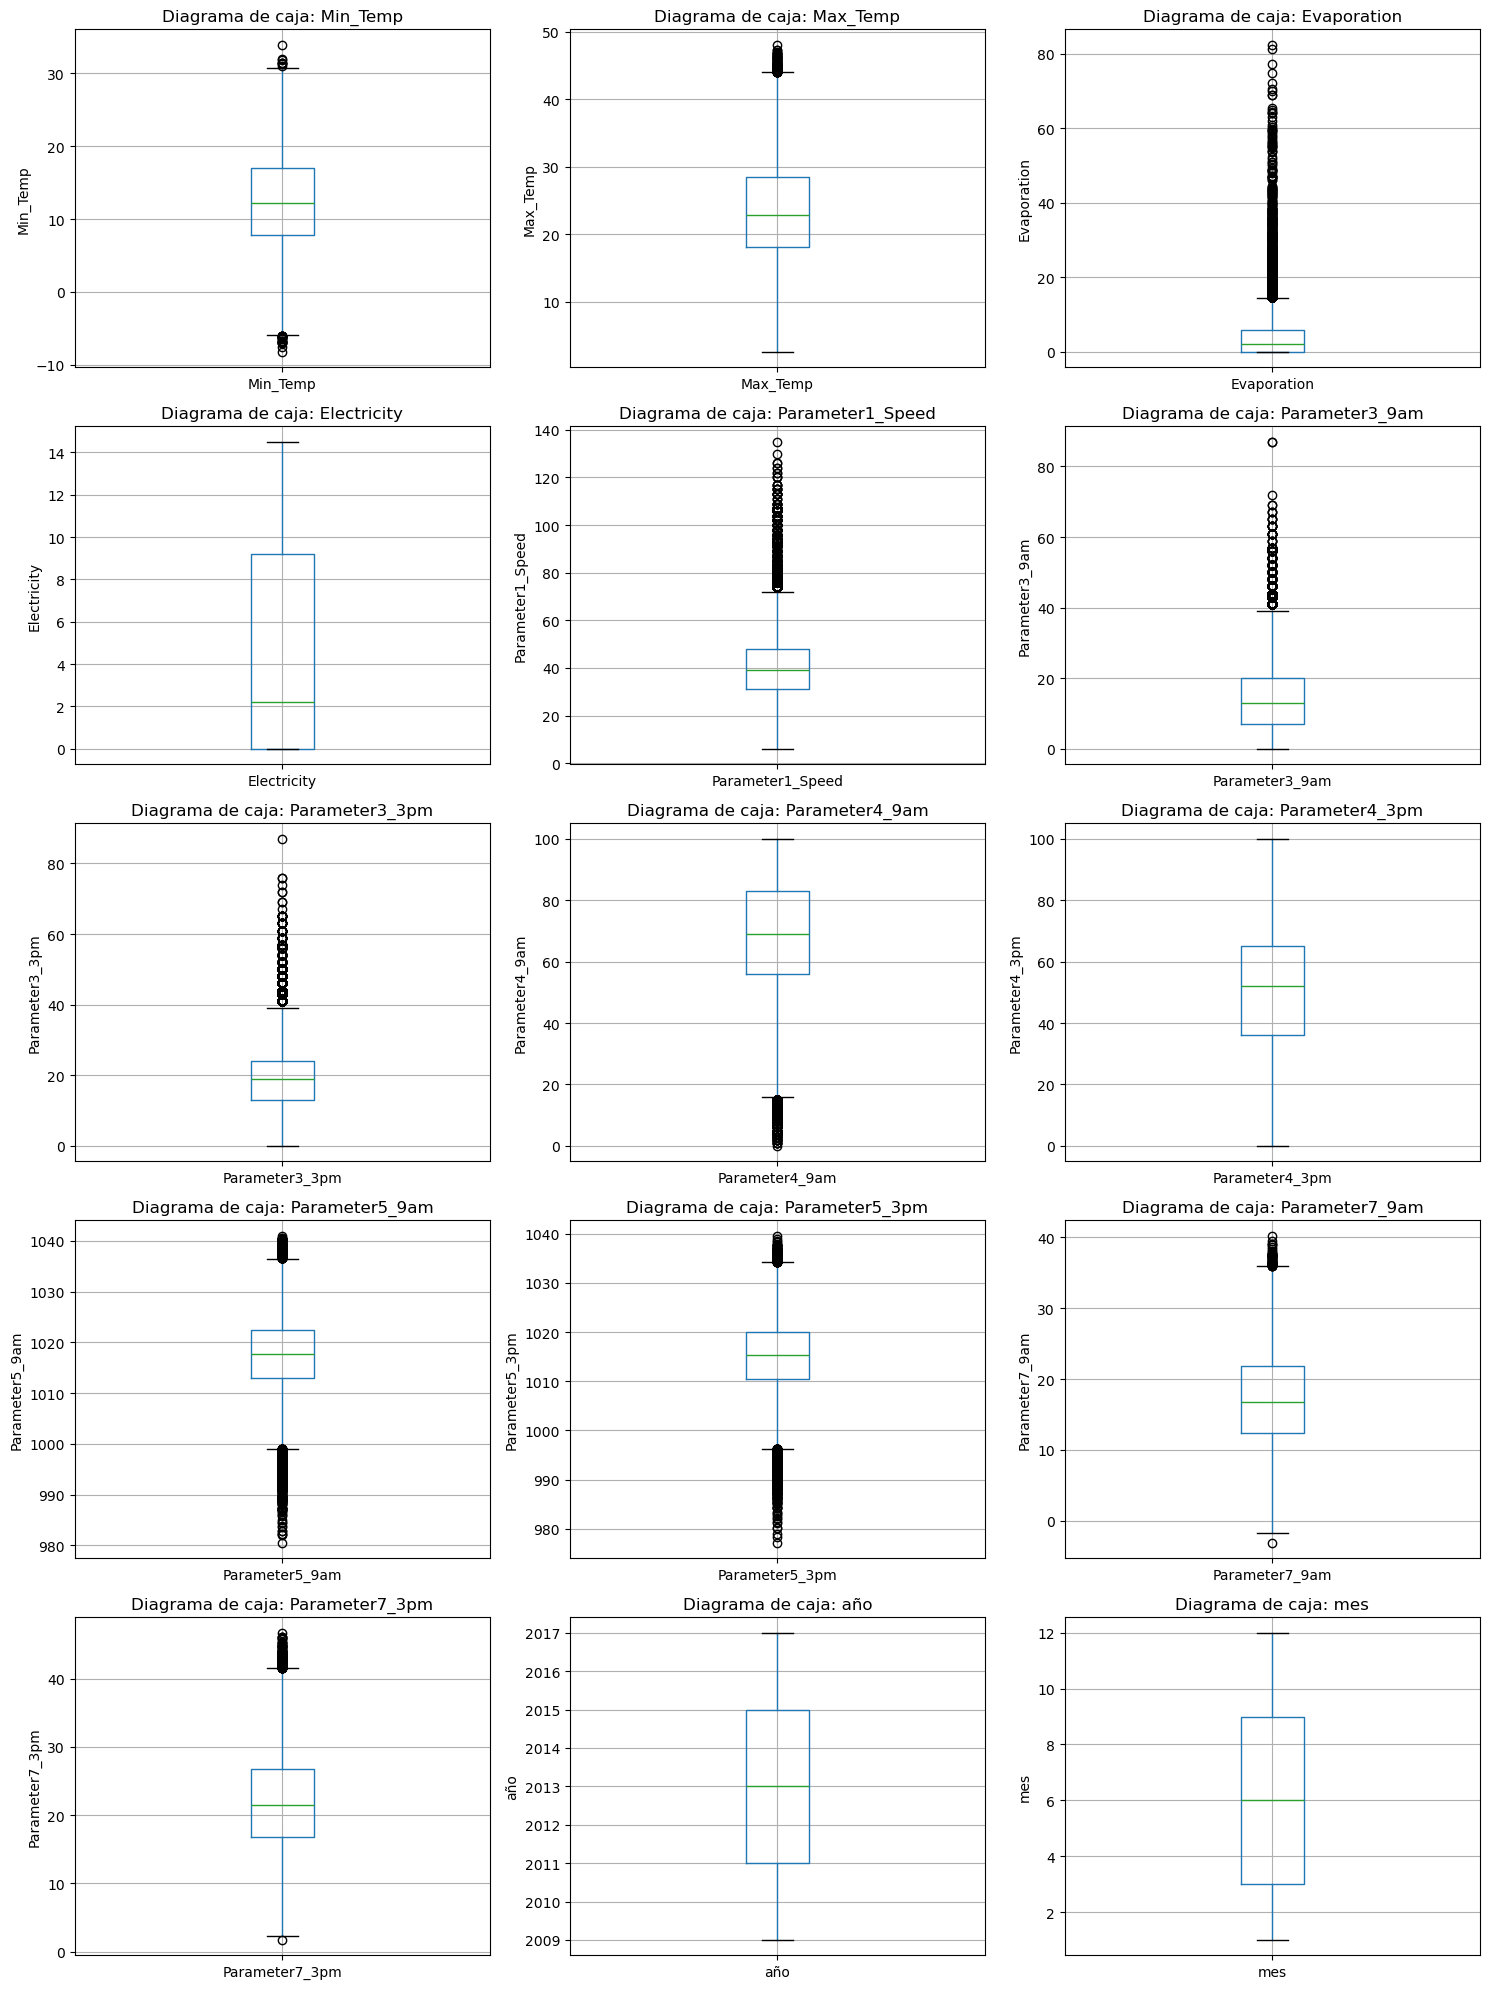

In [11]:
#Graficar con boxplot las variables para identificar outliers
#Y aun que se reconoce la existencia de estos mismos de todas formas se mantendran en el df para los futuros analisis

columnas_numericas = (df.drop(['Location','Leakage','Parameter6_9am', 'Parameter6_3pm'],axis=1)).select_dtypes(include='number').columns

num_columnas = 3
num_graficos = len(columnas_numericas)
num_filas = math.ceil(num_graficos / num_columnas)
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(num_columnas * 5, num_filas * 4))
axes = axes.flatten()

for i, col in enumerate(columnas_numericas):
    df_03.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Diagrama de caja: {col}')
    axes[i].set_ylabel(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


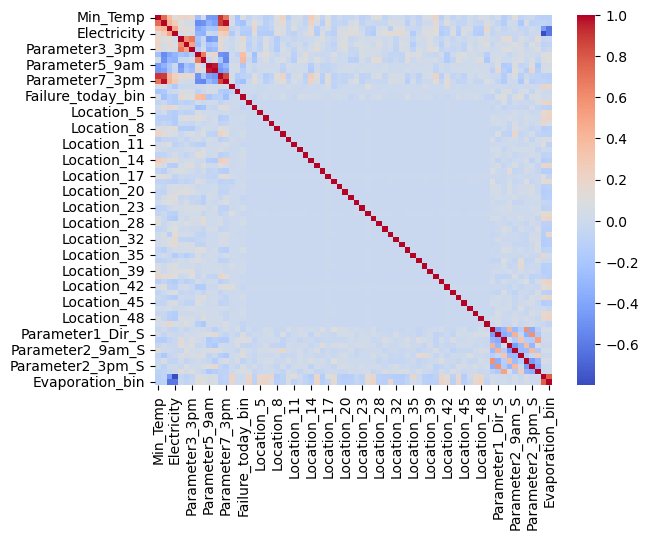

In [12]:
correlation_matrix = df_03.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.show()

In [13]:
#REVISAMOS LAS CORRELACIONES SOBRE 0.8 O BAJO -0.8 PARA PREVEER MULTICOLINEALIDAD

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr = upper.stack().reset_index()
high_corr.columns = ['Variable1', 'Variable2', 'Correlacion']
high_corr_filtrada = high_corr[(high_corr['Correlacion'] > 0.8) | (high_corr['Correlacion'] < -0.8)]
print(high_corr_filtrada.sort_values(by='Correlacion', ascending=False))



          Variable1       Variable2  Correlacion
79         Max_Temp  Parameter7_3pm     0.984704
585  Parameter5_9am  Parameter5_3pm     0.961581
10         Min_Temp  Parameter7_9am     0.902489
78         Max_Temp  Parameter7_9am     0.882529
704  Parameter7_9am  Parameter7_3pm     0.857249


In [14]:
#Dado que parte de la correlación ocurre por parametros que miden lo mismo en distintas horas(por ende tienden a ser parecidos) dejaremos solo 1 horario por parametros
#asumiendo la correlación que pueda quedar del parametro 7 restante con el maximo y minimo de la temperatura, por que el parametro 7 trabaja con temperatura
df_03=df_03.drop(['Parameter5_3pm','Parameter7_3pm','Max_Temp'],axis=1)

### 2. Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R:** El modelo explica el 28% de la varianza en la variable dependiente, lo demas del resultado del modelo podemos mencionar que, luego de haber excluido las variables que generaran alta correlación en el recuadro anterior, podemos mencionar que las variables que mas afectan positivamente a la estimacion del fallo son las variables  Parameter2_9am y Parameter2_3pm para el oeste(W) y sur(S). Y por otro lado las que mas afectan negativamente son las variables de locaciones  destacando entre ellas la locacion 36, 6, 26 y 20, con mayor proporción negativa

In [15]:
y=df_03['Failure_today_bin']
X=df_03.drop(['Failure_today_bin'], axis=1)
X=sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit(cov_type='HC0')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Failure_today_bin   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     701.1
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:55:47   Log-Likelihood:                -44179.
No. Observations:              117793   AIC:                         8.849e+04
Df Residuals:                  117726   BIC:                         8.914e+04
Df Model:                          66                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.7120      0.951  

### 3. Ejecute un modelo *probit* para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R:**  Los resultados sugieren que factores como la Min_Temp (Coef: 0.0223, aumento de 1grado de temperatura aumenta la probabilidad  "Failure_today" en un 2.23% ), Evaporation y los valores de algunos parámetros a las 9 am y 3 pm son los que mas influyen por si solos en la probabilidad de que ocurra el evento "Failure_today", ademas de mencionar que son estadisticamente significativos. La ubicación también tiene un impacto relevante, con algunas locaciones siendo más propensas a fallos que otras, sin embargo estas ultimas en algunos casos no son significativas

In [16]:
model = sm.Probit(y, X)
probit_model = model.fit(cov_type='HC0')
print(probit_model.summary())

mfxp = probit_model.get_margeff()
print(mfxp.summary())

Optimization terminated successfully.
         Current function value: 0.361360
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:      Failure_today_bin   No. Observations:               117793
Model:                         Probit   Df Residuals:                   117726
Method:                           MLE   Df Model:                           66
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3158
Time:                        23:55:49   Log-Likelihood:                -42566.
converged:                       True   LL-Null:                       -62216.
Covariance Type:                  HC0   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               25.9865      4.476      5.806      0.000      17.214      34.759
Min_Temp   

### 4. Ejecute un modelo *logit*  para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

**R:** En este modelo podemos mencionar que dentro de las variables que generan un mayor impacto en el valor resultante de la variable dependiente podemos mencionar que dentro de los que aumentan la probabilidad de failure destacan Min_Temp con un coeficiente estimado de 0.2039 y Electricity con 0.0098, ambos coeficientes significativos. y dentro de los que reducen la probabilidad destaca Evaporation con un coeficiente estimado de  -0.1035 igualmente siendo significativo.

In [17]:
model = sm.Logit(y, X)
logit_model = model.fit(cov_type='HC0')
print(logit_model.summary())

mfxl = logit_model.get_margeff()
print(mfxl.summary())

params = logit_model.params
conf = logit_model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['Odds Ratio', '5%', '95%']
print("Odds Ratios")
print(np.exp(conf).iloc[1:17 , ])

Optimization terminated successfully.
         Current function value: 0.359987
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:      Failure_today_bin   No. Observations:               117793
Model:                          Logit   Df Residuals:                   117726
Method:                           MLE   Df Model:                           66
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3184
Time:                        23:57:23   Log-Likelihood:                -42404.
converged:                       True   LL-Null:                       -62216.
Covariance Type:                  HC0   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               45.1758      7.932      5.696      0.000      29.630      60.722
Min_Temp   

### 5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R=** Desde la base que el modelo MCO no es adecuado cuando la variable dependiente es binaria, ya que puede generar predicciones fuera del rango 0 y 1, y si bien el modelo probit y logit logran una mejor estimacion del resultado opinaria que en este caso seria mas adecuado el modelo Logit, al es más interpretable (por ejemplo, en términos de odds) y es el más utilizado en análisis de variables binarias.
Y las variables robustas podriamos determinar que son Min_Temp, Evaporation y Electricity. dado que las tres cumplen con ser significativas, tener el mismo signo y una magnitud relativamente similar en los 3 modelos.

### 6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R:** Primero que nada se genero una data a nivel mensual y separada por locaciones, que contiene el valor promediado de todas las demas variables exepto por los indicadores NaN de Evaporation y Electricity(1 cuando tienen NaN y 0 cuando no) que fueron generados posteriormente al promediado. Dentro de las variables cuyo coeficiente era de mayor magnitud y a su vez era significativo podemos mencionar la variable Parameter1_Speed dado que ademas de ser significativa aumentaria las fallas en un 4.78%(exp(0.0467)) por unidad y la variable Parameter7_9am  que las aumentaria en un 20%(exp(0.1826))

In [18]:
#filtrar por las fechas de interes(posterior a 2009) y generar columnas de año y mes
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['año'] = df['Date'].dt.year
df['mes'] = df['Date'].dt.month
df_04 = df[df['año'] >= 2009]
#Generar una variable binaria en base a la columna Failure
df_04['Failure_month'] = df_04['Failure_today'].map({'Yes': 1, 'No': 0})

df_05 = df_04.drop(['Date','Parameter6_9am', 'Parameter6_3pm','Leakage','Failure_today','Parameter1_Dir','Parameter2_9am','Parameter2_3pm'], axis=1)

In [19]:

# Definir cómo queremos agregar
agg_dict = {col: 'mean' for col in df_05.columns if col not in ['año', 'mes','Location', 'Failure_month']}
agg_dict['Failure_month'] = 'sum'

# Agrupar y aplicar agregaciones
df_mensual = df_05.groupby(['año', 'mes','Location'], as_index=False).agg(agg_dict)

df_mensual['Electricity_bin'] = df_mensual['Electricity'].isna().astype(int)
df_mensual.Electricity=df_mensual.Electricity.fillna(0)
df_mensual['Evaporation_bin'] = df_mensual['Evaporation'].isna().astype(int)
df_mensual.Evaporation=df_mensual.Evaporation.fillna(0)

df_mensual=df_mensual.dropna()

df_mensual

,año,mes,Location,Min_Temp,Max_Temp,Evaporation,Electricity,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_month,Electricity_bin,Evaporation_bin
0,2009,1,1,17.932258,32.003226,13.419048,12.180000,39.645161,10.161290,17.966667,37.612903,23.827586,1014.025806,1012.166667,23.658065,30.750000,0.0,0,0
2,2009,1,3,16.312903,34.658065,0.000000,0.000000,42.677419,11.935484,18.548387,41.903226,17.870968,1013.064516,1009.770968,22.993548,32.964516,1.0,1,1
3,2009,1,4,22.422581,36.058065,13.561290,10.525806,51.258065,18.516129,25.032258,37.096774,24.516129,1008.461290,1004.732258,29.241935,34.487097,3.0,0,0
4,2009,1,5,16.154839,32.780645,0.000000,0.000000,41.935484,7.419355,17.466667,65.516129,35.933333,1015.451613,1012.353333,22.390323,31.156667,3.0,1,1
5,2009,1,6,10.467742,28.529032,0.000000,0.000000,48.000000,20.500000,21.806452,50.354839,24.225806,1012.873333,1011.496667,18.577419,26.593548,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,2017,6,45,4.424000,14.744000,1.344000,4.632000,24.040000,4.960000,9.280000,97.840000,67.760000,1028.816000,1026.476000,6.736000,13.696000,3.0,0,0
4688,2017,6,46,10.100000,18.356000,0.000000,0.000000,34.120000,16.440000,16.440000,87.200000,70.880000,1025.720000,1023.492000,13.168000,17.304000,13.0,1,1
4689,2017,6,47,8.736000,18.616000,0.000000,0.000000,34.000000,9.520000,16.320000,88.520000,67.280000,1024.156000,1022.168000,12.948000,17.360000,9.0,1,1
4690,2017,6,48,11.657895,17.700000,0.000000,0.000000,38.894737,15.052632,19.842105,73.315789,69.421053,1026.163158,1024.126316,14.726316,16.757895,4.0,1,1


In [20]:
y = df_mensual['Failure_month']
X2=df_mensual.drop(['Failure_month','año', 'mes'], axis=1)
X2=sm.add_constant(X2)
poisson=sm.GLM(y,X2,family=sm.families.Poisson()).fit()
print(poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_month   No. Observations:                 4076
Model:                            GLM   Df Residuals:                     4059
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9367.4
Date:                Thu, 24 Apr 2025   Deviance:                       4925.1
Time:                        23:58:56   Pearson chi2:                 4.55e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8668
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               22.0480      2.467  

### 7. Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

**R:** Según el análisis, y dado que el valor de alpha es mayor a 1 y es significativo, podemos concluir que el modelo presenta sobre-dispersión. Además, el valor p es igual a 0.000, lo que refuerza la evidencia de que existe una sobre-dispersión importante en los datos.

In [21]:
print(df_mensual['Failure_month'].describe())

count    4076.000000
mean        6.547596
std         4.482926
min         0.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        25.000000
Name: Failure_month, dtype: float64


<Axes: xlabel='plambda', ylabel='Count'>

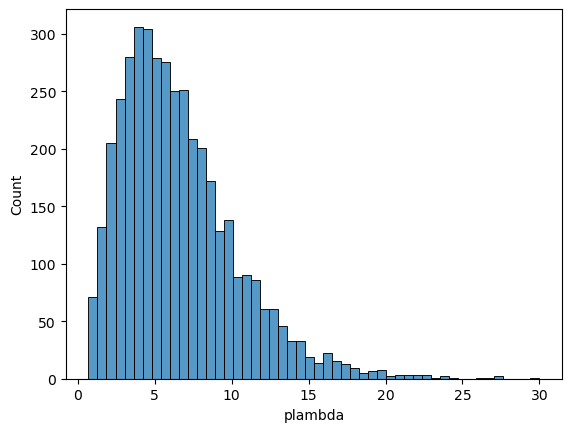

In [22]:
df_mensual['plambda'] = poisson.mu
sns.histplot(data=df_mensual, x="plambda")

In [23]:
aux=((y-poisson.mu)**2-poisson.mu)/poisson.mu
auxr=sm.OLS(aux,poisson.mu).fit()
print(auxr.summary())

                                 OLS Regression Results                                
Dep. Variable:          Failure_month   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.698
Date:                Thu, 24 Apr 2025   Prob (F-statistic):                       0.193
Time:                        23:58:57   Log-Likelihood:                         -10575.
No. Observations:                4076   AIC:                                  2.115e+04
Df Residuals:                    4075   BIC:                                  2.116e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [24]:
model_nb = smf.glm(formula = "Failure_month ~ Location + Min_Temp + Max_Temp + Evaporation + Electricity + Parameter1_Speed + Parameter3_9am + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Parameter5_3pm + Parameter7_9am + Parameter7_3pm + Electricity_bin + Evaporation_bin", data=df_mensual, family=sm.families.NegativeBinomial()).fit()
print(model_nb.summary())

alpha = np.exp(auxr.params[0])
print(f"Alpha (sobre-dispersión): {alpha}")



                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_month   No. Observations:                 4076
Model:                            GLM   Df Residuals:                     4059
Model Family:        NegativeBinomial   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11410.
Date:                Thu, 24 Apr 2025   Deviance:                       1122.2
Time:                        23:58:57   Pearson chi2:                     848.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2628
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           24.8161      7.263  

### 8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R:** Ejecutamos un modelo de binomial Negativa con el aplha estimado anteriormente y podemos mencionar que Electricity, Parameter1_Speed, Parameter3_3pm y Parameter7_9am son clave en la predicción del número de fallas mensuales. dado que todas ellas son significativas y tienen valores de coeficiente de una magnitud razonable.

In [25]:
negbin=sm.GLM(y,X2,family=sm.families.NegativeBinomial(alpha=1.0088)).fit()
print(negbin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_month   No. Observations:                 4076
Model:                            GLM   Df Residuals:                     4059
Model Family:        NegativeBinomial   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11424.
Date:                Thu, 24 Apr 2025   Deviance:                       1116.1
Time:                        23:58:57   Pearson chi2:                     843.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2612
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               24.8281      7.291  

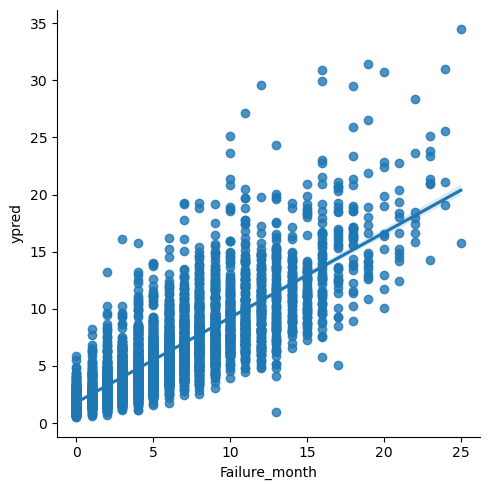

In [26]:
df_mensual['ypred'] = negbin.predict(X2)
sns.lmplot(data=df_mensual, x='Failure_month', y='ypred')

### 9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R:** existen diferencias entre los modelosprincipalmente por que el modelo de Poisson subestima la variabilidad de los datos mientras que en binomial negativa esta puede adaptarse mejor a los datos llegando a estimaciones más precisas y confiables. Considero que seria mejor utilizar binomial negativa dado que Poisson no captura adecuadamente la sobre-dispersión presente en los datos y el modelo Binomial Negativa ajusta la sobre-dispersión y finalmente las variables robustas son Electricity, Parameter1_Speed y Parameter7_9am.